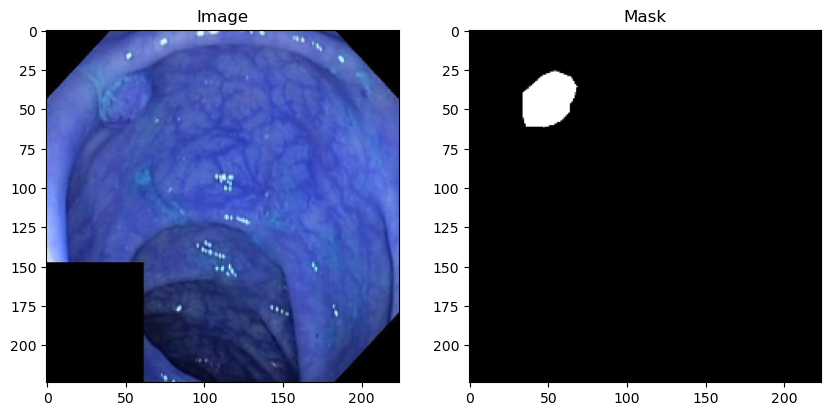

In [12]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths to your dataset
image_path = "images"
mask_path = "masks"

# Load and preprocess data
def load_data(image_path, mask_path, image_size=(224, 224)):  # Resize to (224, 224)
    images, masks = [], []
    for file_name in os.listdir(image_path):
        # Load image and mask
        img = cv2.imread(os.path.join(image_path, file_name))
        mask = cv2.imread(os.path.join(mask_path, file_name), 0)  # Load as grayscale
        
        # Resize and normalize
        img = cv2.resize(img, image_size) / 255.0
        mask = cv2.resize(mask, image_size) / 255.0
        
        images.append(img)
        masks.append(mask)
    
    images = np.array(images, dtype=np.float32)
    masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)  # Add channel dimension
    return images, masks


# Load and split dataset
images, masks = load_data(image_path, mask_path)
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Display sample
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(y_train[0].squeeze(), cmap="gray")
plt.title("Mask")
plt.show()


In [18]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Build the DeepLabV3-like model using MobileNetV2 as a backbone
def build_deeplabv3(input_shape=(224, 224, 3)):  # Input shape is (224, 224, 3)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

    # Extract the features from the base model
    base_model.trainable = False  # Freeze the backbone layers

    # Build DeepLabV3 model using MobileNetV2 backbone
    x = base_model.output
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Decoder part (upsampling to match the input image size)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Add another upsampling layer to get closer to the target size
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Add another upsampling layer to match the target size (224x224)
    x = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Final upsampling to match the exact target output size (224x224)
    x = layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Final output layer with 1 channel (for binary segmentation)
    output = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    return model

# Build the model
deeplabv3_model = build_deeplabv3(input_shape=(224, 224, 3))  # Input shape updated

# Compile the model for training
deeplabv3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Check the model summary
deeplabv3_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 6,193,569 (23.63 MB)

 Trainable params: 3,934,065 (15.01 MB)

 Non-trainable params: 2,259,504 (8.62 MB)

In [21]:
history = deeplabv3_model.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_val, y_val))


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.9667 - loss: 0.0673 - val_accuracy: 0.9027 - val_loss: 0.3794
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9684 - loss: 0.0627 - val_accuracy: 0.9019 - val_loss: 0.2939
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.9682 - loss: 0.0635 - val_accuracy: 0.9023 - val_loss: 0.3048
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9712 - loss: 0.0541 - val_accuracy: 0.9061 - val_loss: 0.3140
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9727 - loss: 0.0510 - val_accuracy: 0.9062 - val_loss: 0.2901
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.9745 - loss: 0.0445 - val_accuracy: 0.9056 - val_loss: 0.2947
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9776 - loss: 0.0374 - val_accuracy: 0.9067 - val_loss: 0.2783
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.9771 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


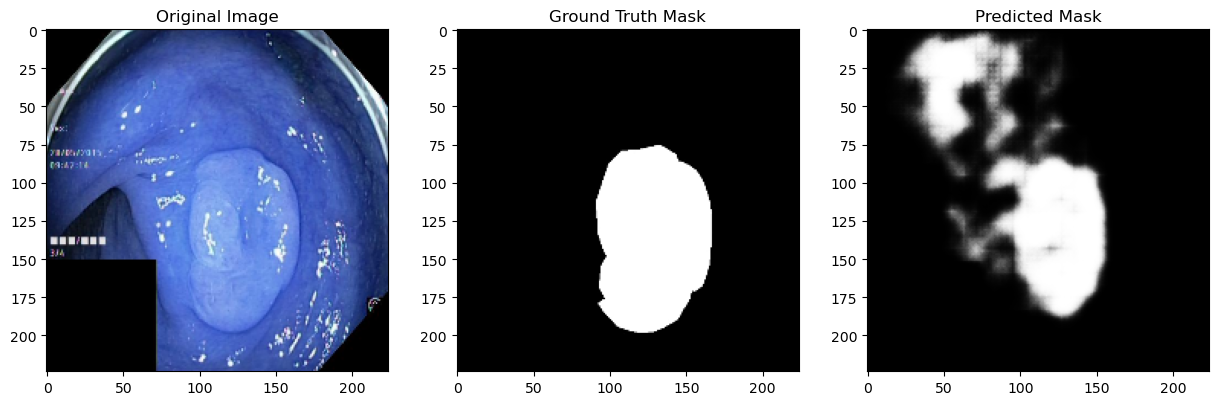

In [23]:
import matplotlib.pyplot as plt

# Predict on a validation image
predicted_mask = deeplabv3_model.predict(X_val[:1])[0]

# Plot original image, ground truth mask, and predicted mask
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(X_val[0])
plt.title("Original Image")

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(y_val[0].squeeze(), cmap="gray")
plt.title("Ground Truth Mask")

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")

plt.show()


In [25]:
# Save the trained model
deeplabv3_model.save("deeplabv3_trained_model.keras")


In [26]:
#loading model (use it if creating a new notebook)
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("deeplabv3_trained_model.h5")

# Now you can use the model for predictions or further training
